In [20]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression

#additional libraries
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import cross_validate


# annoying warnings
import warnings
warnings.filterwarnings('ignore')

#additional libraries, Payman
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
import glob
np.random.seed(42)


In [16]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

In [17]:
def oversample_extremes(data, low_val=42, low_weight=2, high_val=48, high_weight=2):
    '''
    A function that will create duplicate rows of specified rows in order to weight certain rows in machine learning training
    
    INPUTS:
    data: a pandas dataframe
    low_val: value of 'Quality' below which we will duplicate rows
    low_weight: integer of effective weight desired for low values
    high_val: value of 'Quality' above which we will duplicate rows
    high_weight: integer for effective weight desired for high values
    
    RETURNS:
    newdata: a pandas dataframe with duplicated rows according to the arguments passed
    
    NOTES:
    
    'low_weight' and 'high_weight' both need integer values and correspond to the effective weight of the sample compared
    to the rest of the data in the dataframe. For an example, a weight of 2 would mean creating 1 duplicate (so the
    row is now in the data twice), and a weight of 1 would return the same dataset (no additional duplicates created)
    
    Default cutoff values correspond to roughly anything outside the IQR
    '''
    # identify rows of interest
    low_df = data.loc[data['Quality'] < low_val]
    high_df = data.loc[data['Quality'] > high_val]
    
    newdata = data.copy()
    
    # loop to add on all the rows
    
    for i in range(low_weight-1): #pythonic indexing...
        newdata = newdata.append(low_df, ignore_index = True)
    for i in range(high_weight-1):
        newdata = newdata.append(high_df, ignore_index = True)
    
    return(newdata)
    

### XGBRegressor

**Without sampling**


Dataset: no_tempinc.csv


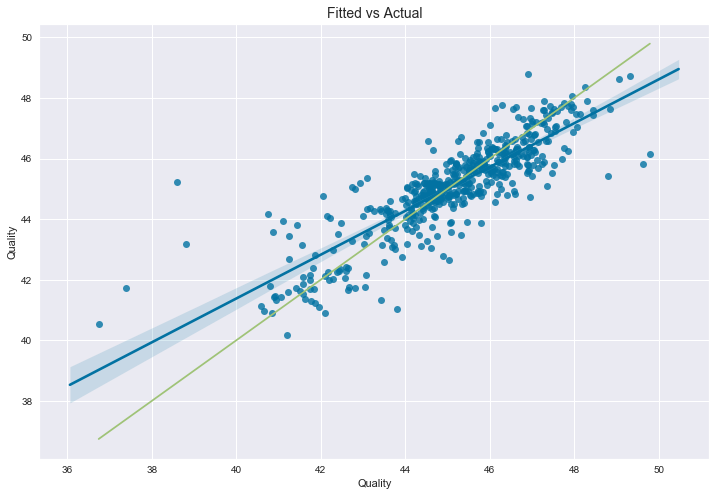


Dataset: no_tempinc_minmax.csv


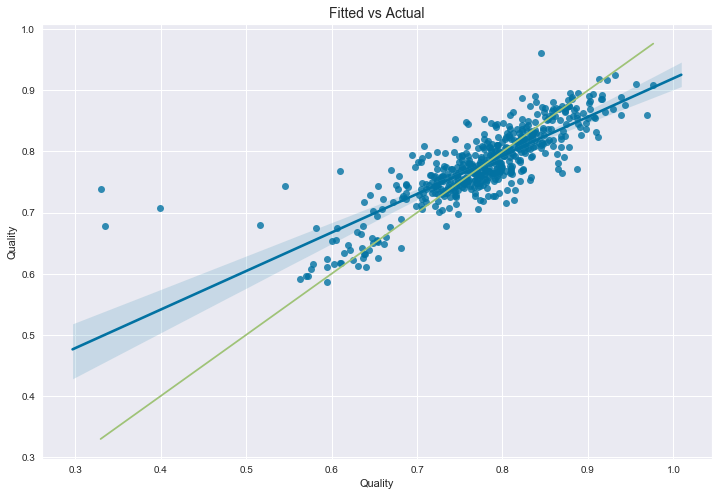


Dataset: no_tempinc_standard.csv


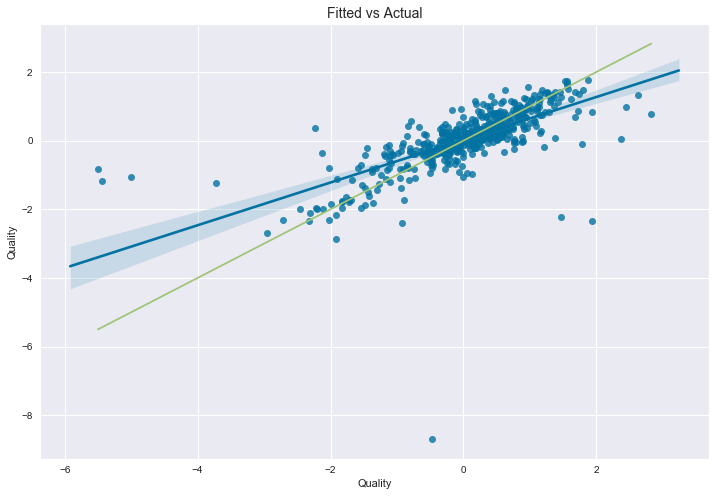


Dataset: tempinc.csv


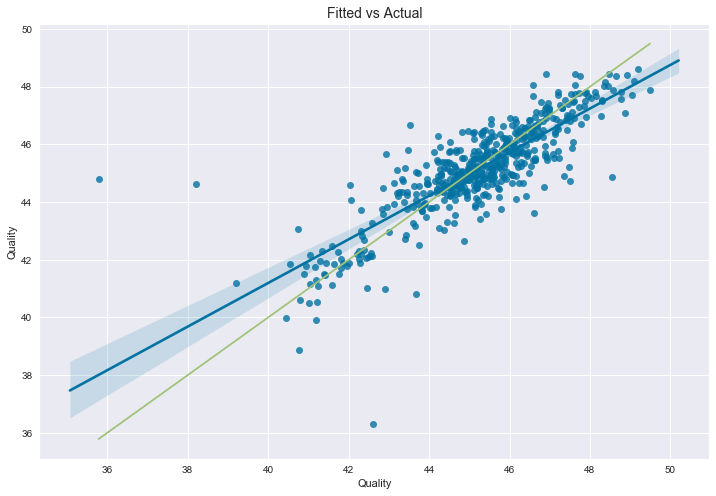


Dataset: tempinc_minmax.csv


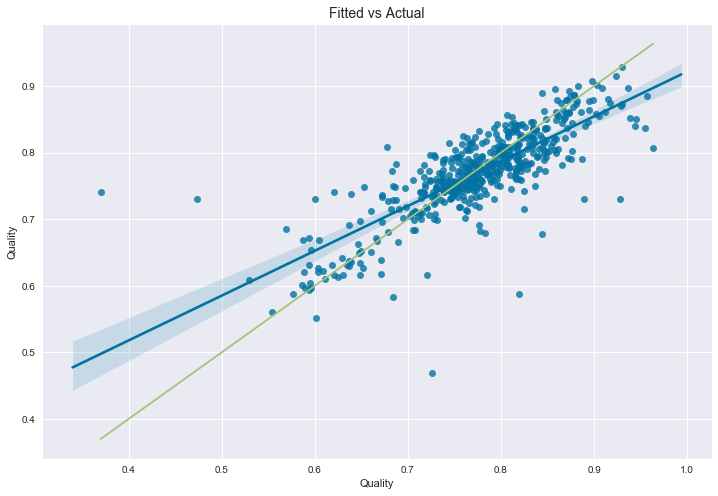


Dataset: tempinc_standard.csv


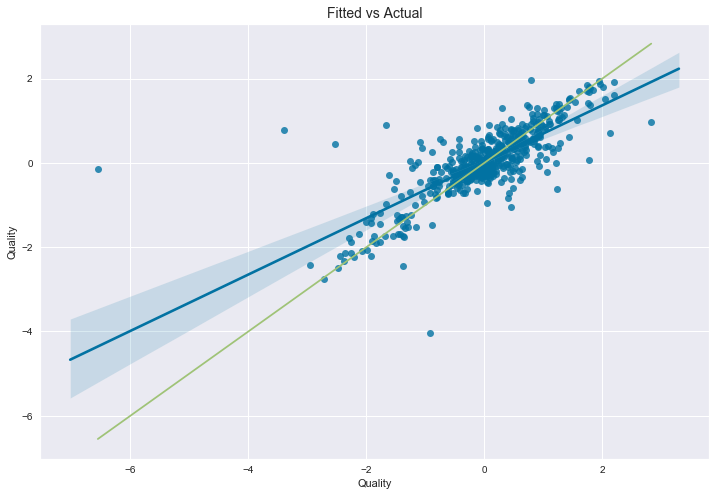

In [75]:
xgb_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_train = train['Quality']
    train.drop(['Quality'], axis = 1, inplace = True)
    X_train = train
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val
    
    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test

    xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15, random_state=3)
    

    xgb_fit = xgb_ml.fit(X_train, y_train)
    xgb_preds = xgb_fit.predict(X_val)
#     print(xgb_ml.feature_importances_)
    
    mae = mean_absolute_error(y_val, xgb_preds)
    mse = mean_squared_error(y_val, xgb_preds)
    r_squared = r2_score(y_val, xgb_preds)
    
    xgb_dict[str(file)] = {}
    xgb_dict[str(file)]['mae'] = mae
    xgb_dict[str(file)]['mse'] = mse
    xgb_dict[str(file)]['r_squared'] = r_squared
    xgb_dict[str(file)]['feat_imp'] = xgb_ml.feature_importances_
    
    plt.figure(figsize=(12,8))
    print('\nDataset:', str(file))
    sns.set_style("darkgrid")
    ax = sns.regplot(x=y_val, y=xgb_preds)
#     ax = sns.lineplot(x=y_val, y=xgb_preds)
    ax = sns.lineplot(x=y_val, y=y_val, palette="00D415")
    plt.title("Fitted vs Actual",  fontsize='14')
    plt.show()
    

In [76]:
xgb_df = pd.DataFrame.from_dict(xgb_dict)

In [77]:
xgb_df.T

,feat_imp,mae,mse,r_squared
no_tempinc.csv,"[0.014778786, 0.012110634, 0.72693264, 0.01071...",0.623218,0.867807,0.726152
no_tempinc_minmax.csv,"[0.003926826, 0.0, 0.0052027493, 0.8923139, 0....",0.0294431,0.00213537,0.67362
no_tempinc_standard.csv,"[0.0031910946, 0.0, 0.0044828155, 0.90917504, ...",0.37878,0.516231,0.431847
tempinc.csv,"[0.01034902, 0.009485841, 0.58652014, 0.009247...",0.66427,1.02459,0.675197
tempinc_minmax.csv,"[0.00506558, 0.0, 0.0046725473, 0.9111807, 0.0...",0.029336,0.00210761,0.632834
tempinc_standard.csv,"[0.0024164517, 0.0, 0.0044812383, 0.90447885, ...",0.339237,0.344146,0.597988


**With sampling**


Dataset: no_tempinc.csv Weight: 1


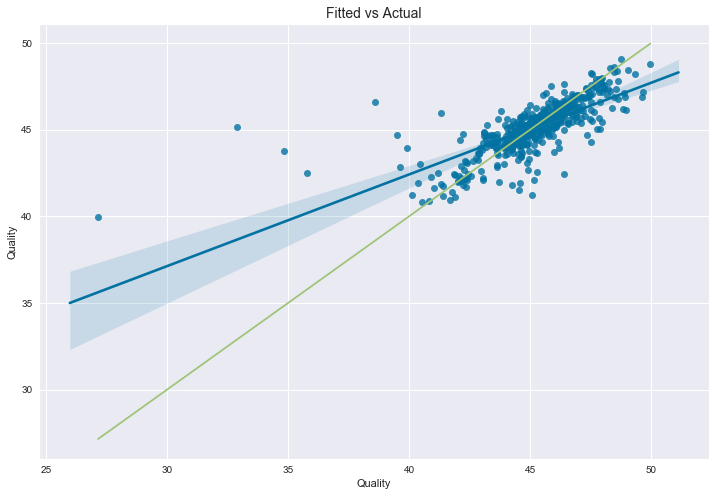


Dataset: no_tempinc.csv Weight: 3


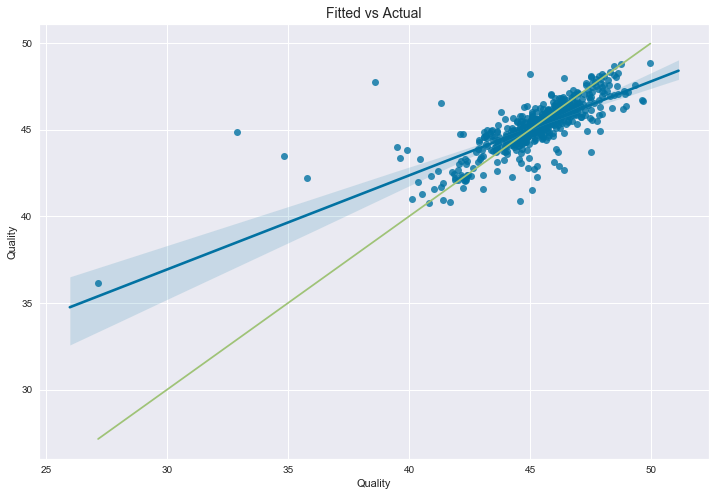


Dataset: no_tempinc.csv Weight: 5


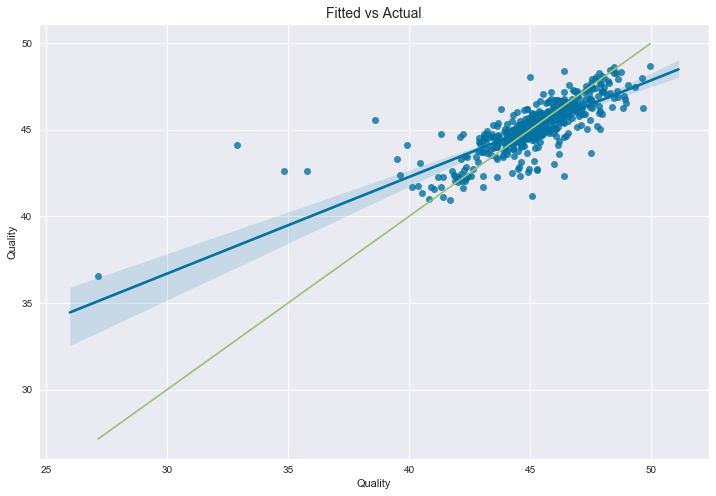


Dataset: no_tempinc_minmax.csv Weight: 1


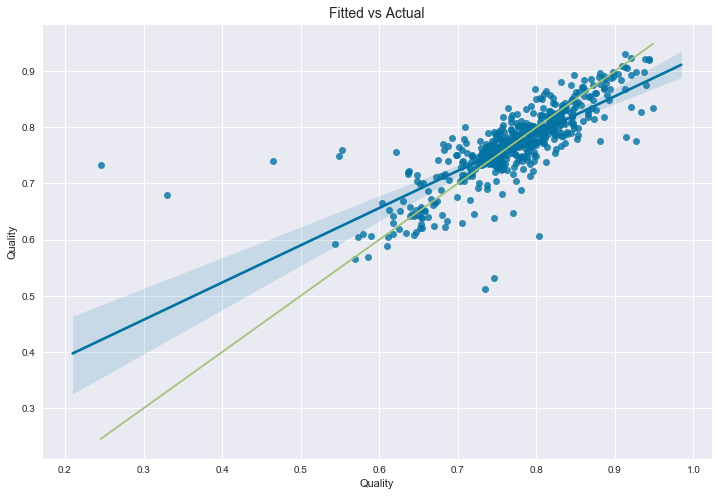


Dataset: no_tempinc_minmax.csv Weight: 3


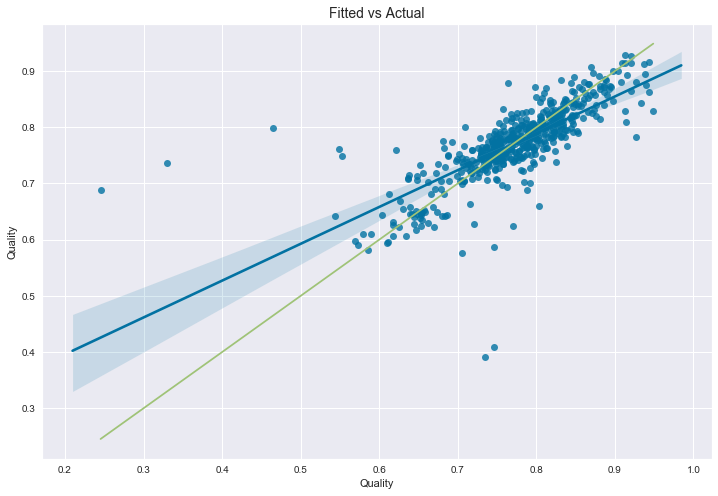


Dataset: no_tempinc_minmax.csv Weight: 5


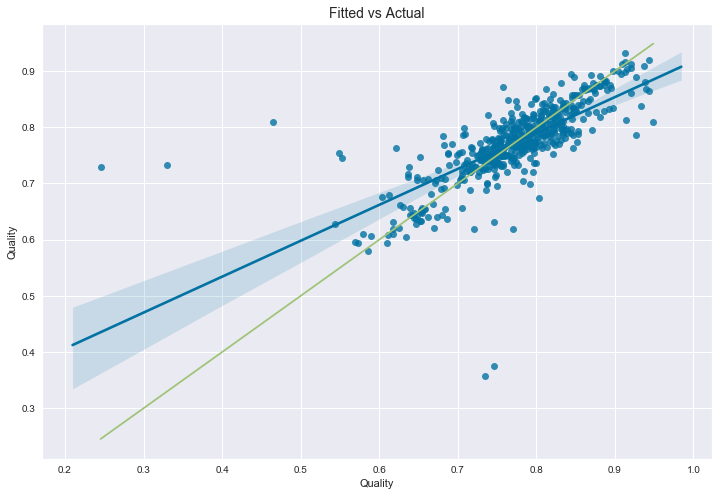


Dataset: no_tempinc_standard.csv Weight: 1


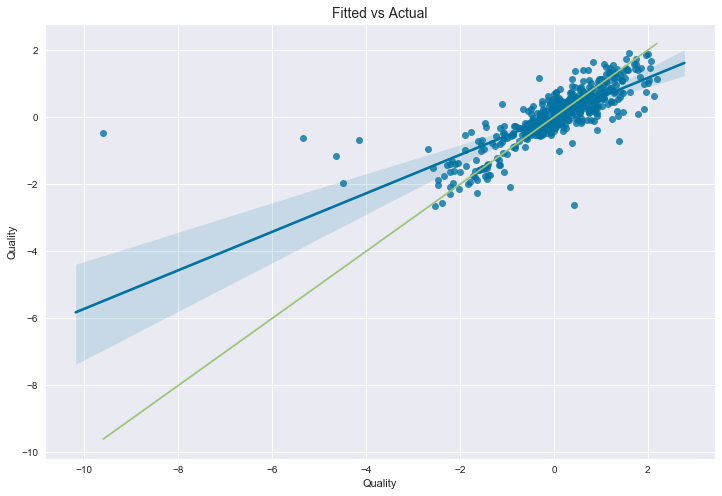


Dataset: no_tempinc_standard.csv Weight: 3


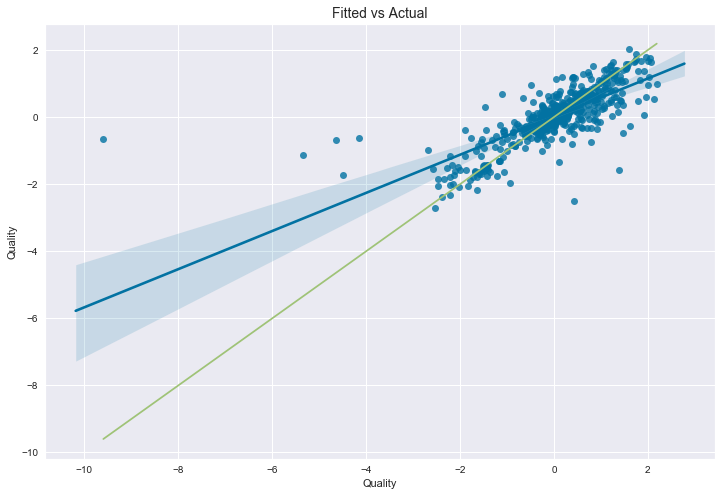


Dataset: no_tempinc_standard.csv Weight: 5


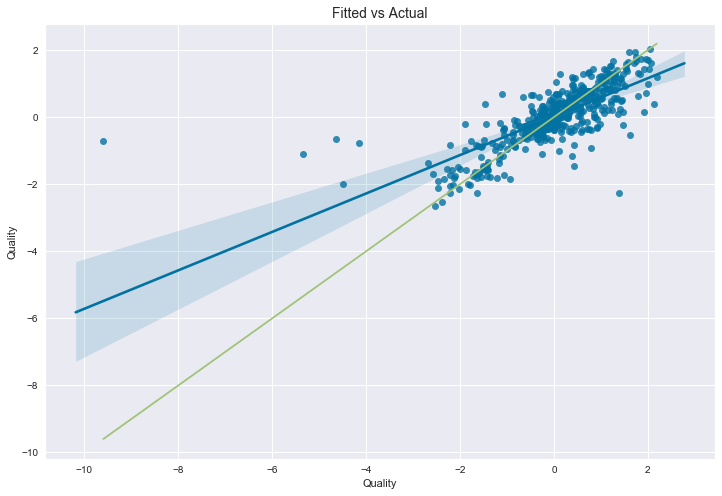


Dataset: tempinc.csv Weight: 1


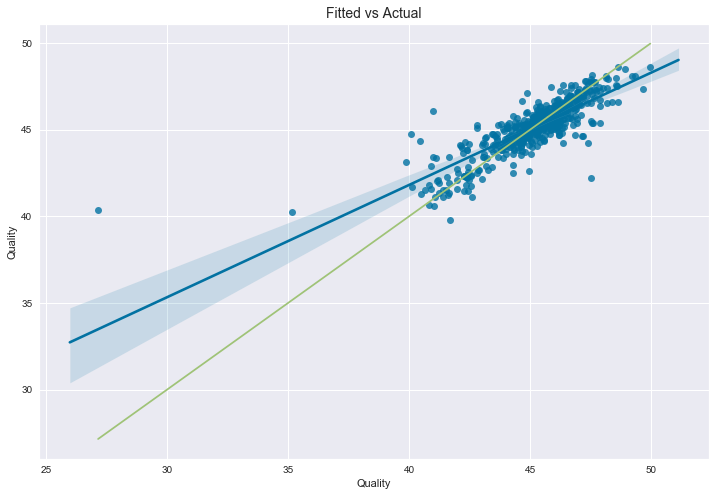


Dataset: tempinc.csv Weight: 3


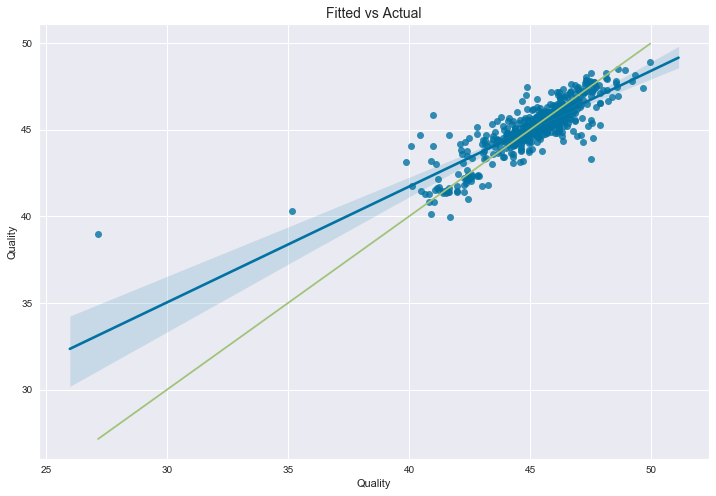


Dataset: tempinc.csv Weight: 5


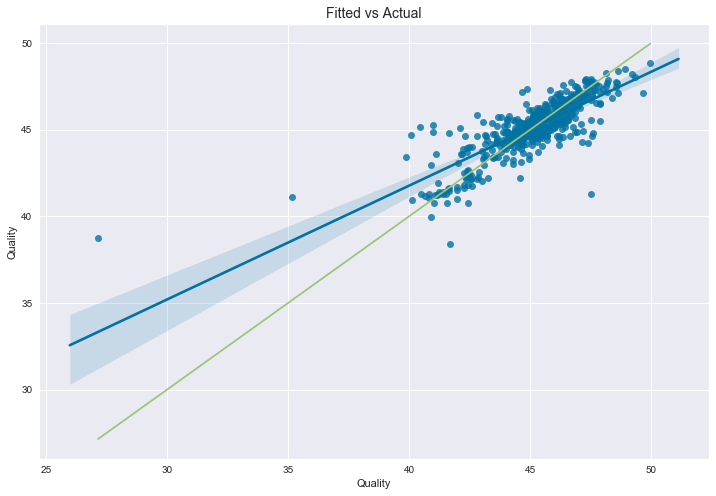


Dataset: tempinc_minmax.csv Weight: 1


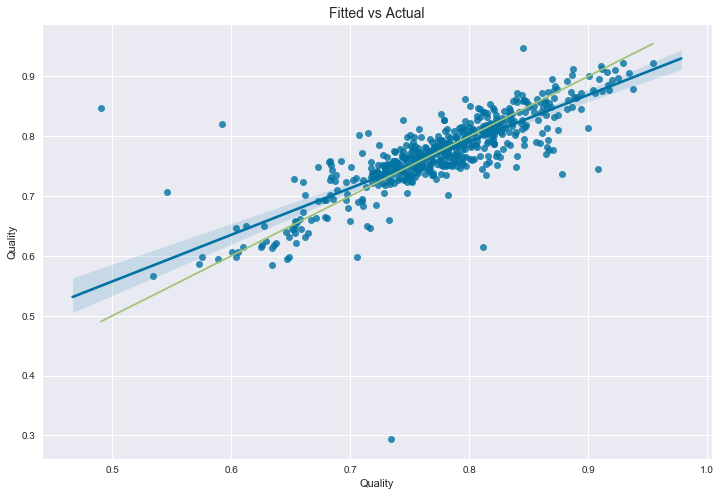


Dataset: tempinc_minmax.csv Weight: 3


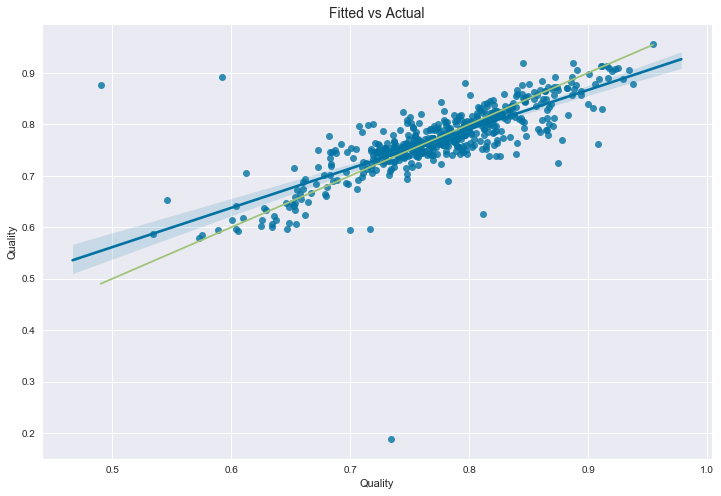


Dataset: tempinc_minmax.csv Weight: 5


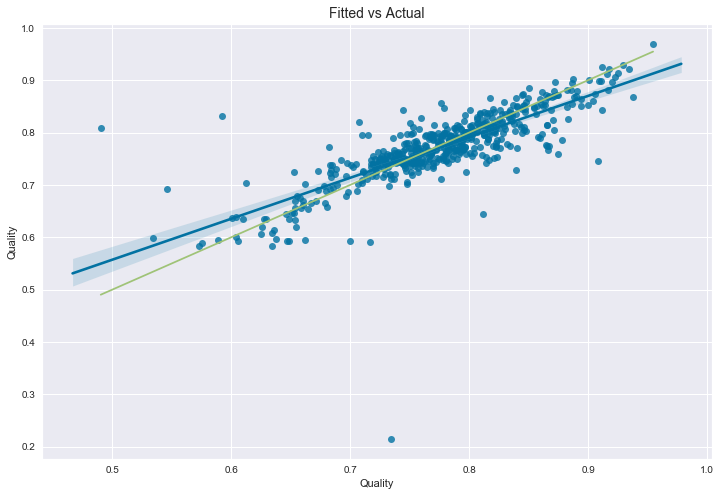


Dataset: tempinc_standard.csv Weight: 1


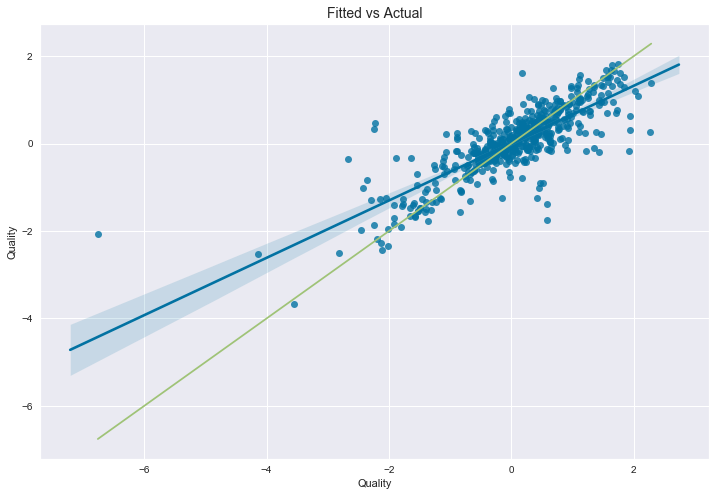


Dataset: tempinc_standard.csv Weight: 3


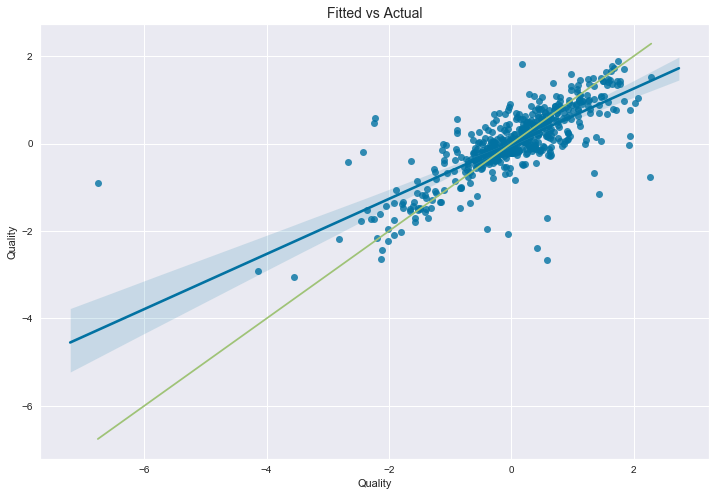


Dataset: tempinc_standard.csv Weight: 5


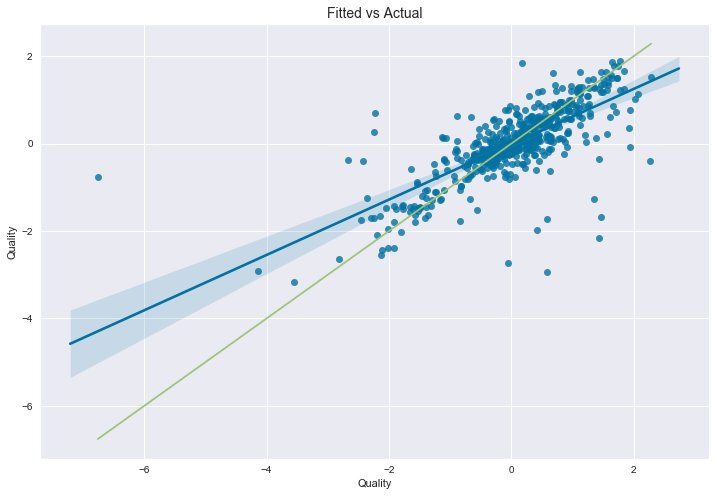

In [52]:
xgb_s_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):

    df = pd.read_csv(file)
    temp_train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val

    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    for w in range(1,6,2):
#         print('Weight:',w)
        temp_df = oversample_extremes(temp_train, low_weight=w, high_weight = w)

        y_train = temp_df['Quality']
        temp_df.drop(['Quality'], axis = 1, inplace = True)
        X_train = temp_df

        xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15, random_state=3)
        
        xgb_fit = xgb_ml.fit(X_train, y_train)
        xgb_preds = xgb_fit.predict(X_val)
        
        mae = mean_absolute_error(y_val, xgb_preds)
        mse = mean_squared_error(y_val, xgb_preds)
        r_squared = r2_score(y_val, xgb_preds)
        
        xgb_s_dict[str(file) + '_w' + str(w)] = {}
        xgb_s_dict[str(file) + '_w' + str(w)]['mae'] = mae
        xgb_s_dict[str(file) + '_w' + str(w)]['mse'] = mse
        xgb_s_dict[str(file) + '_w' + str(w)]['r_squared'] = r_squared
        xgb_s_dict[str(file) + '_w' + str(w)]['feat_imp'] = xgb_ml.feature_importances_
        
        plt.figure(figsize=(12,8))
        print('\nDataset:', str(file), "Weight:", w)
        sns.set_style("darkgrid")
        ax = sns.regplot(x=y_val, y=xgb_preds)
        ax = sns.lineplot(x=y_val, y=y_val, palette="00D415")
        plt.title("Fitted vs Actual",  fontsize='14')
        plt.show()

In [63]:
xgb_s_df = pd.DataFrame.from_dict(xgb_s_dict)

In [64]:
xgb_summ = pd.concat([xgb_df.T, xgb_s_df.T])

In [65]:
xgb_summ['Model'] = 'XGB'

### RandomForestRegressor

In [111]:
#get best hyper parameters for the model
# hyperparameters = {
#     'n_estimators': range(90, 201, 10),
#     'max_depth': range(2, 12, 2),
#     'min_samples_split' : range(2, 10, 2),
#     'min_samples_leaf' : list(range(1, 10, 1))
# #     'min_weight_fraction_leaf' : (0.0)
#                               }

# grid = GridSearchCV(base_model, param_grid=hyperparameters, n_jobs=-1)
# grid.fit(X_train, y_train)
# print('score = {}\nparams={}'.format(grid.best_score_, grid.best_params_))

**Without sampling**


Dataset: no_tempinc.csv


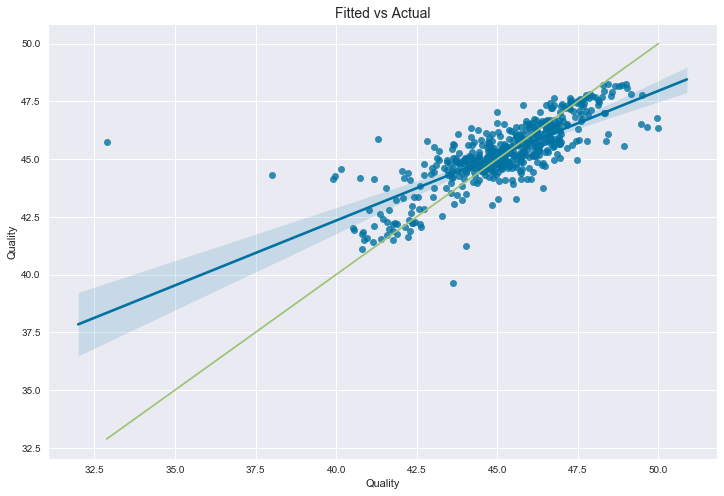


Dataset: no_tempinc_minmax.csv


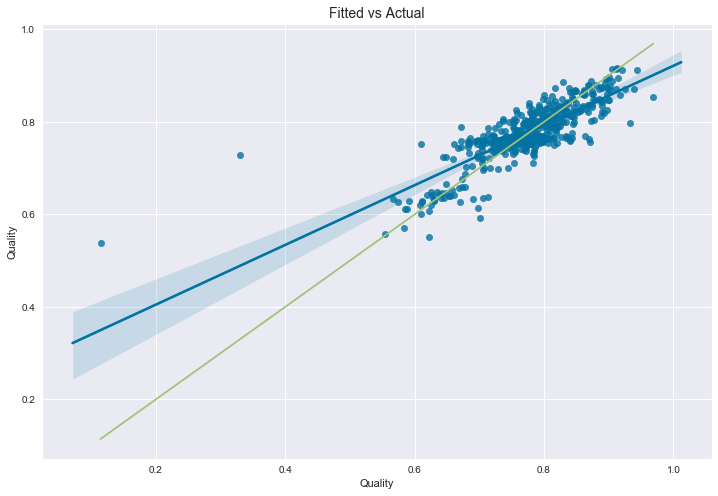


Dataset: no_tempinc_standard.csv


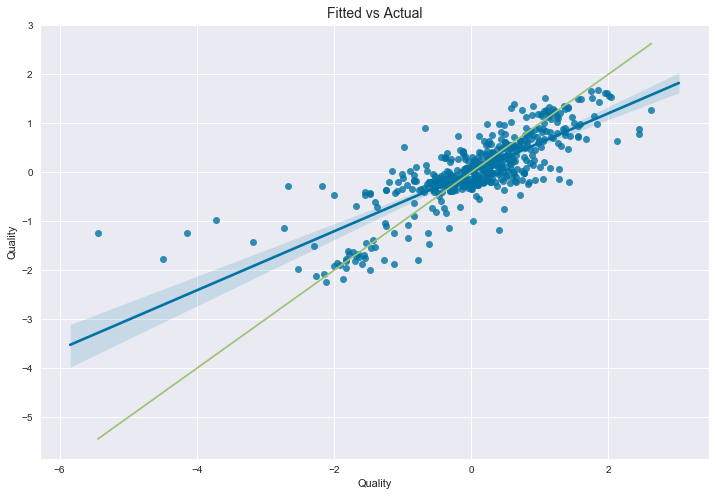


Dataset: tempinc.csv


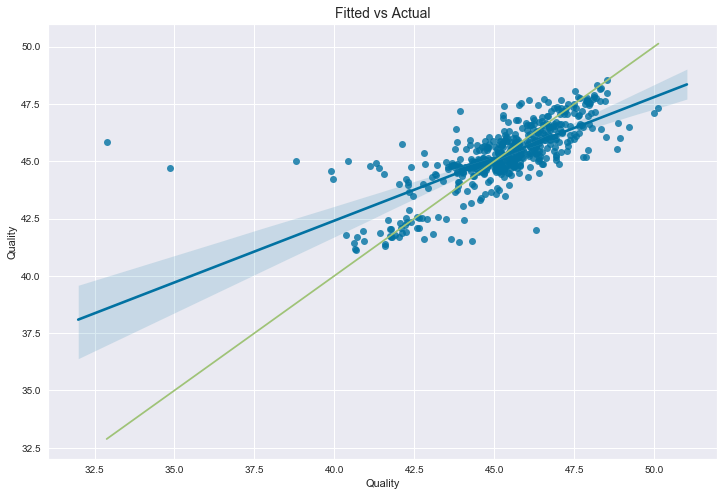


Dataset: tempinc_minmax.csv


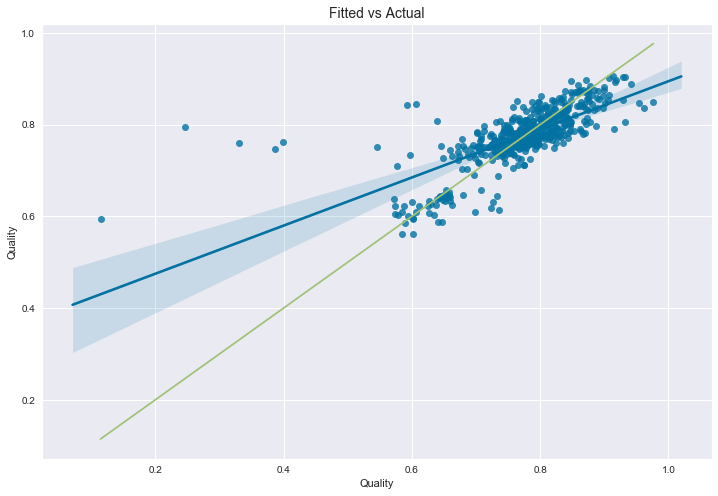


Dataset: tempinc_standard.csv


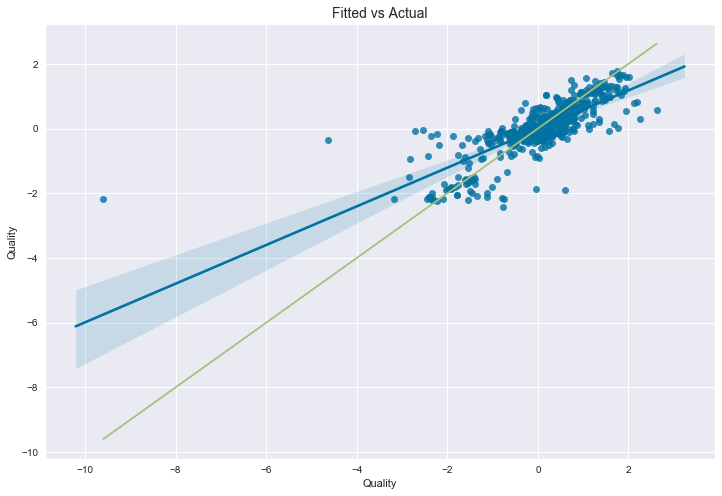

In [53]:
rf_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_train = train['Quality']
    train.drop(['Quality'], axis = 1, inplace = True)
    X_train = train
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val
    
    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                    min_samples_split = 9,min_samples_leaf = 4,
                    min_weight_fraction_leaf= 0.0)
    
    rf_fit = rf_reg.fit(X_train, y_train)
    rf_reg_preds = rf_fit.predict(X_val)
    
    mae = mean_absolute_error(y_val, rf_reg_preds)
    mse = mean_squared_error(y_val, rf_reg_preds)
    r_squared = r2_score(y_val, rf_reg_preds)
    
    rf_dict[str(file)] = {}
    rf_dict[str(file)]['mae'] = mae
    rf_dict[str(file)]['mse'] = mse
    rf_dict[str(file)]['r_squared'] = r_squared
    rf_dict[str(file)]['feat_imp'] = rf_reg.feature_importances_
    
        
    plt.figure(figsize=(12,8))
    print('\nDataset:', str(file))
    sns.set_style("darkgrid")
    ax = sns.regplot(x=y_val, y=rf_reg_preds)
    ax = sns.lineplot(x=y_val, y=y_val, palette="00D415")
    plt.title("Fitted vs Actual",  fontsize='14')
    plt.show()

In [57]:
rf_df = pd.DataFrame.from_dict(rf_dict)

**With sampling**


Dataset: no_tempinc.csv Weight: 1


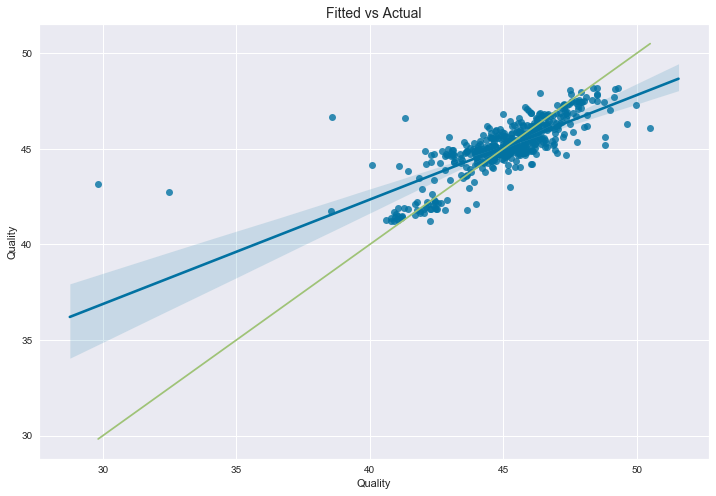


Dataset: no_tempinc.csv Weight: 3


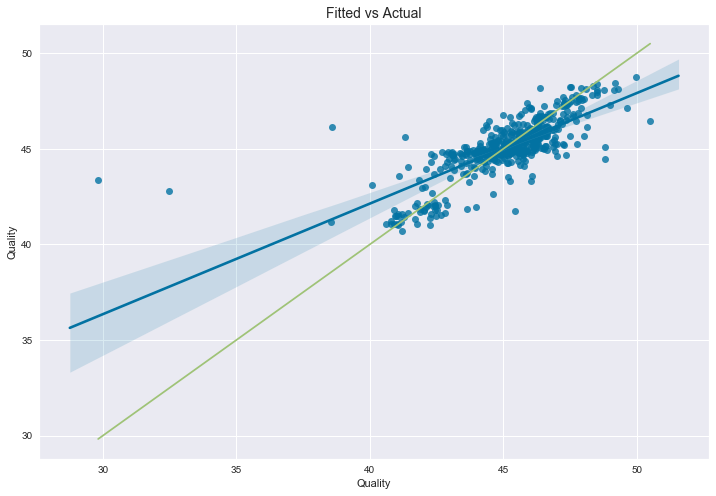


Dataset: no_tempinc.csv Weight: 5


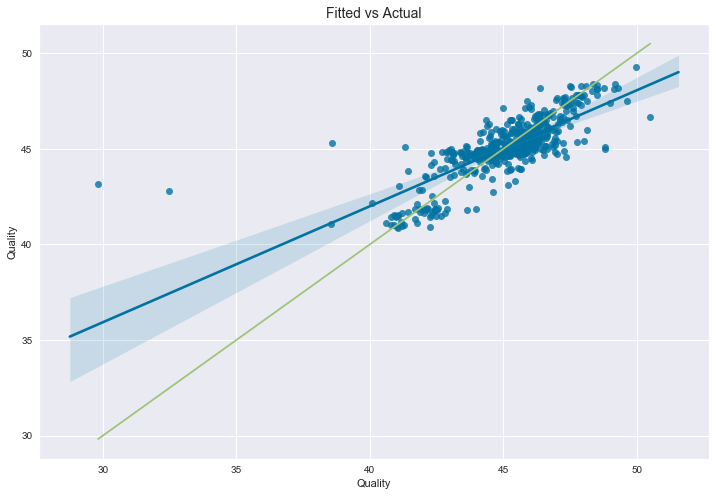


Dataset: no_tempinc_minmax.csv Weight: 1


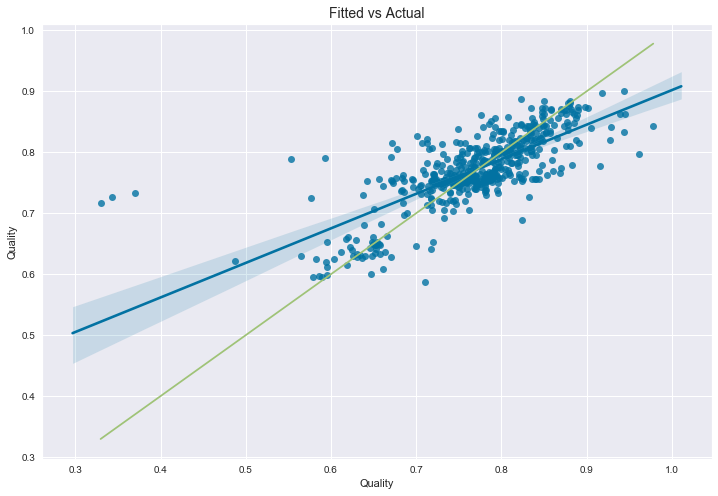


Dataset: no_tempinc_minmax.csv Weight: 3


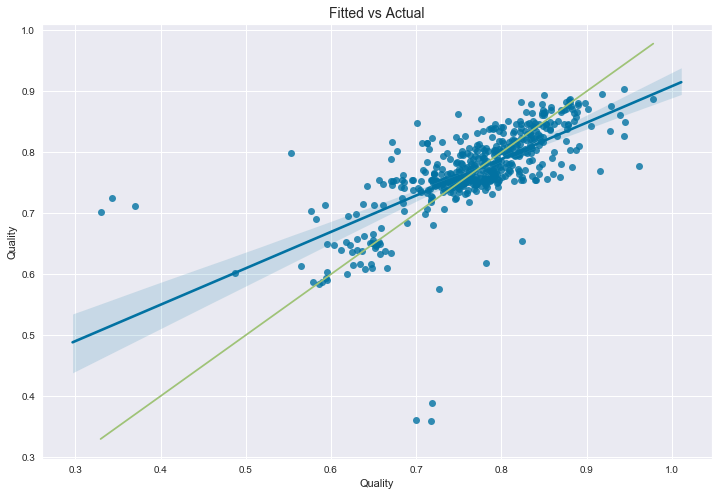


Dataset: no_tempinc_minmax.csv Weight: 5


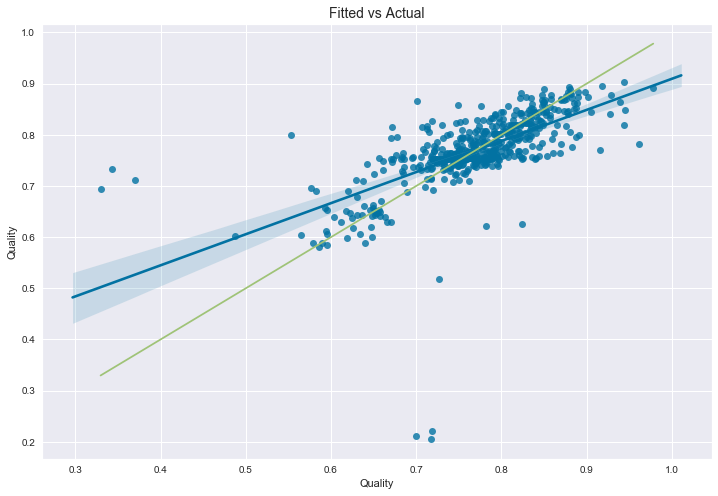


Dataset: no_tempinc_standard.csv Weight: 1


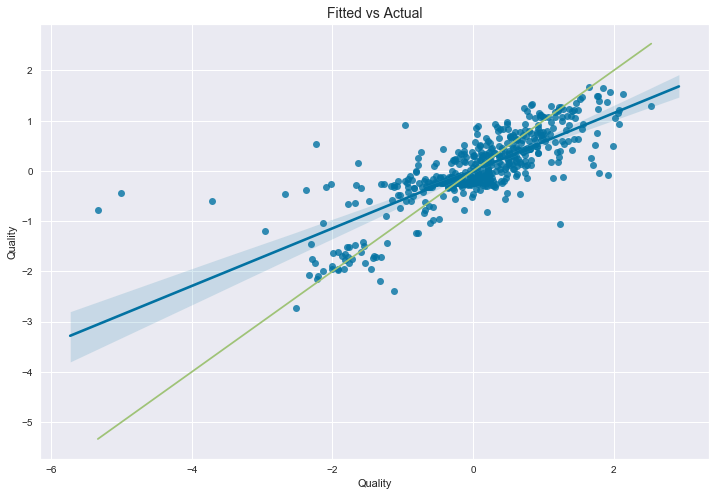


Dataset: no_tempinc_standard.csv Weight: 3


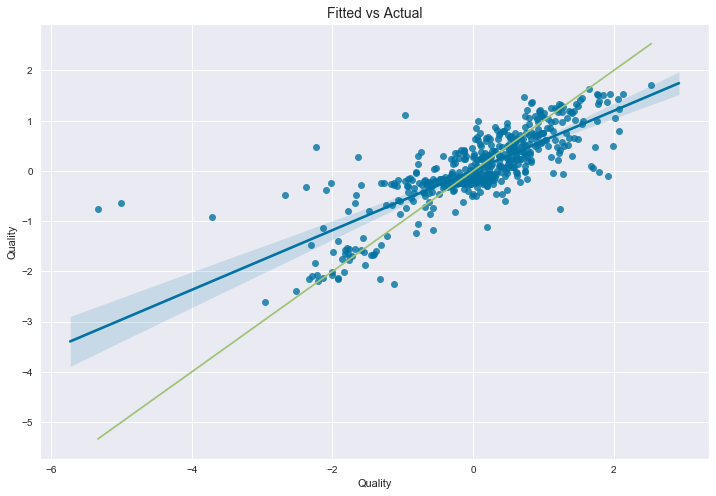


Dataset: no_tempinc_standard.csv Weight: 5


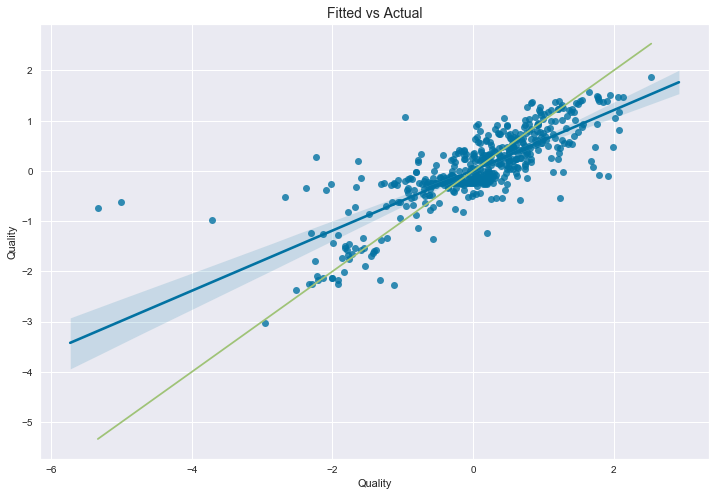


Dataset: tempinc.csv Weight: 1


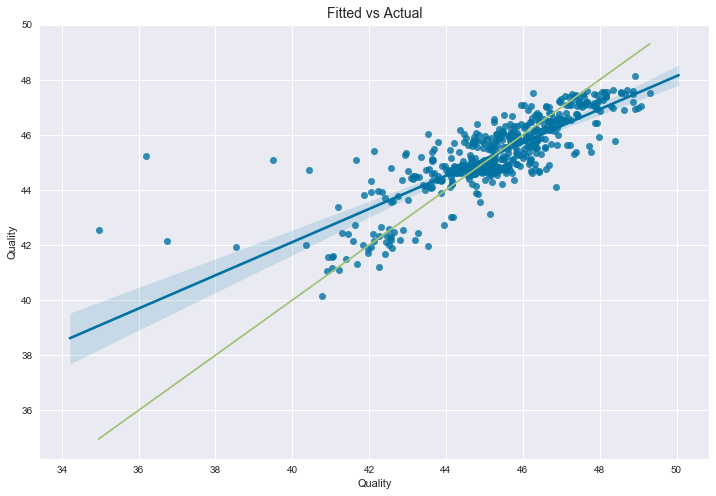


Dataset: tempinc.csv Weight: 3


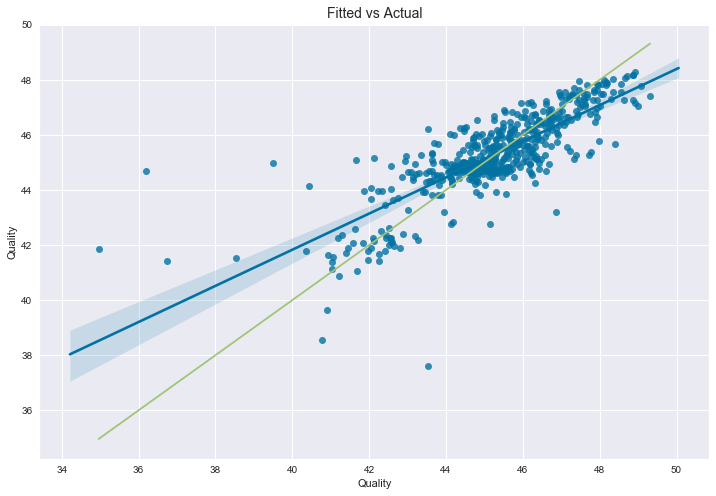


Dataset: tempinc.csv Weight: 5


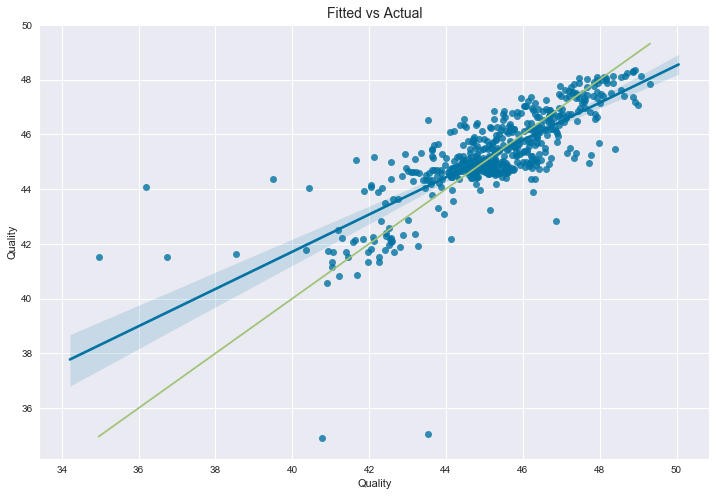


Dataset: tempinc_minmax.csv Weight: 1


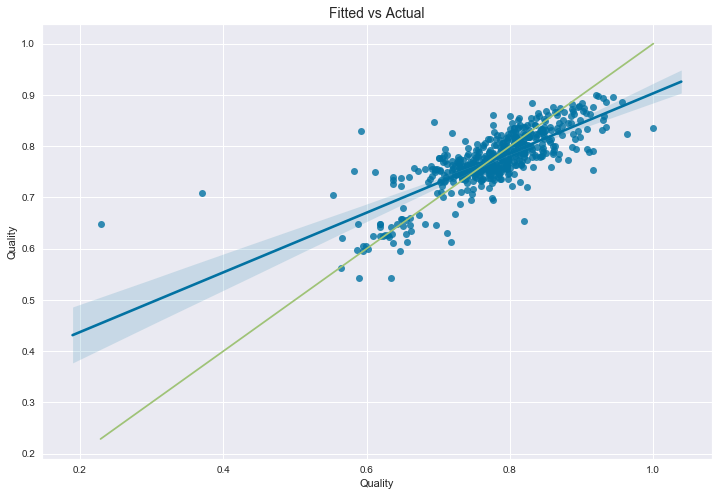


Dataset: tempinc_minmax.csv Weight: 3


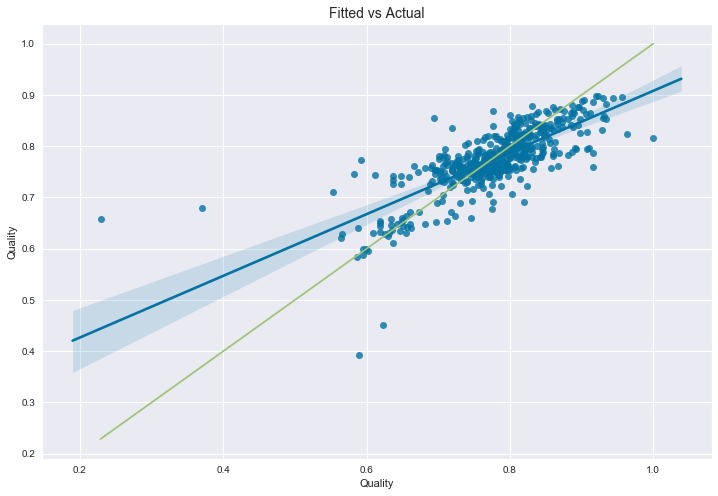


Dataset: tempinc_minmax.csv Weight: 5


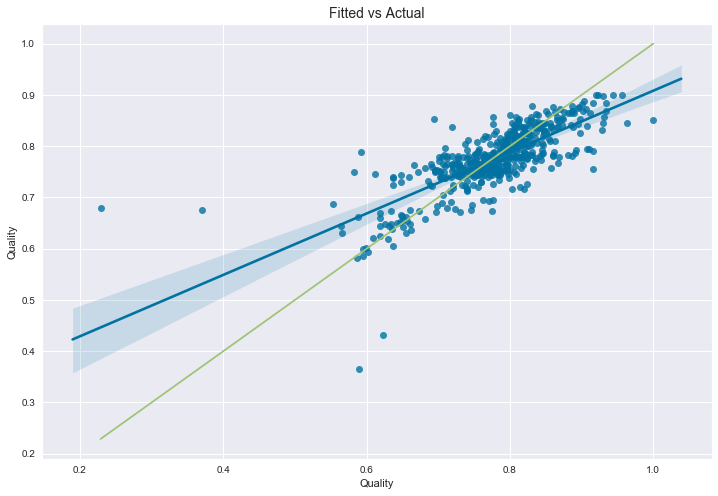


Dataset: tempinc_standard.csv Weight: 1


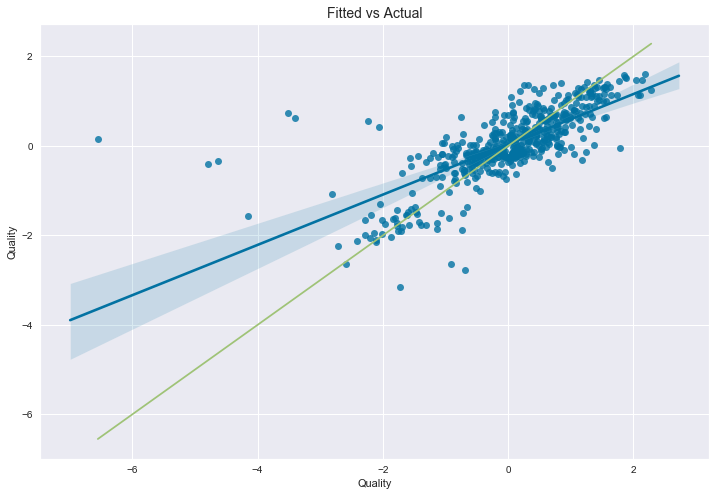


Dataset: tempinc_standard.csv Weight: 3


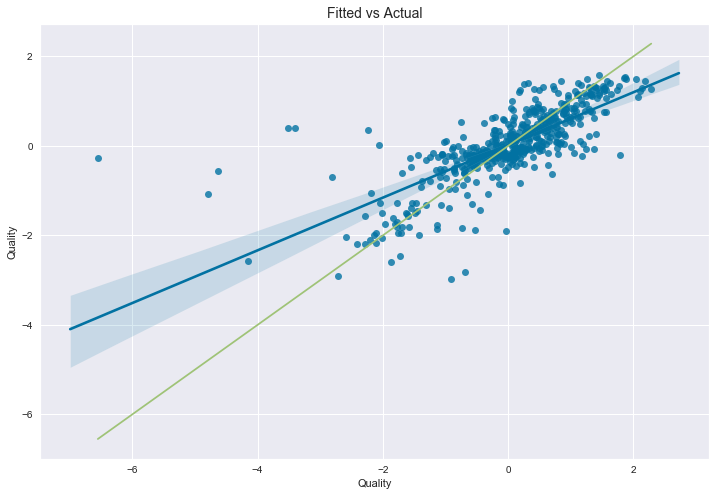


Dataset: tempinc_standard.csv Weight: 5


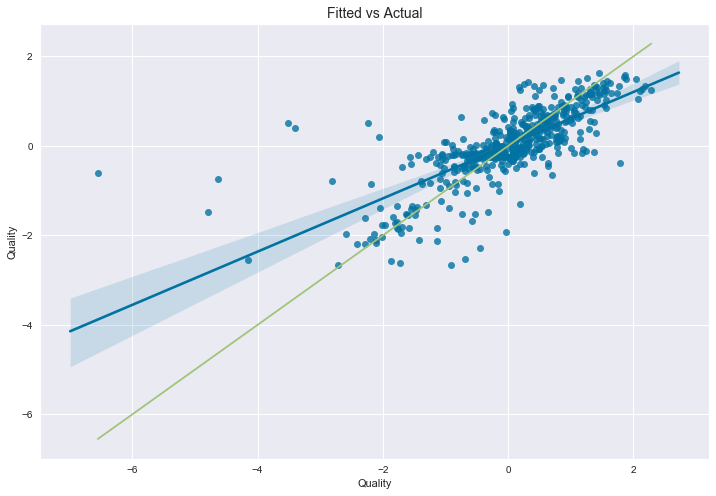

In [54]:
rf_s_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    temp_train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val

    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    for w in range(1,6,2):
#         print('Weight:',w)
        temp_df = oversample_extremes(temp_train, low_weight=w, high_weight = w)

        y_train = temp_df['Quality']
        temp_df.drop(['Quality'], axis = 1, inplace = True)
        X_train = temp_df

        rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                        min_samples_split = 9,min_samples_leaf = 4,
                        min_weight_fraction_leaf= 0.0)

        rf_fit = rf_reg.fit(X_train, y_train)
        rf_reg_preds = rf_fit.predict(X_val)
        
        mae = mean_absolute_error(y_val, rf_reg_preds)
        mse = mean_squared_error(y_val, rf_reg_preds)
        r_squared = r2_score(y_val, rf_reg_preds)
        
        rf_s_dict[str(file) + '_w' + str(w)] = {}
        rf_s_dict[str(file) + '_w' + str(w)]['mae'] = mae
        rf_s_dict[str(file) + '_w' + str(w)]['mse'] = mse
        rf_s_dict[str(file) + '_w' + str(w)]['r_squared'] = r_squared
        rf_s_dict[str(file) + '_w' + str(w)]['feat_imp'] = rf_reg.feature_importances_
        
        plt.figure(figsize=(12,8))
        print('\nDataset:', str(file), "Weight:", w)
        sns.set_style("darkgrid")
        ax = sns.regplot(x=y_val, y=rf_reg_preds)
        ax = sns.lineplot(x=y_val, y=y_val, palette="00D415")
        plt.title("Fitted vs Actual",  fontsize='14')
        plt.show()

In [58]:
rf_s_df = pd.DataFrame.from_dict(rf_s_dict)

In [59]:
rf_summ = pd.concat([rf_df.T, rf_s_df.T])

In [60]:
rf_summ['Model'] = 'RandomForest'

In [66]:
model_summ = pd.concat([xgb_summ, rf_summ])

In [67]:
model_summ

,feat_imp,mae,mse,r_squared,Model
no_tempinc.csv,"[0.0062582884, 0.005476134, 0.8823048, 0.00470...",0.61631,1.15633,0.700626,XGB
no_tempinc_minmax.csv,"[0.005461614, 0.0, 0.0054155774, 0.9224022, 0....",0.0310978,0.00223239,0.596163,XGB
no_tempinc_standard.csv,"[0.0012624868, 0.0, 0.002173304, 0.9618917, 0....",0.351313,0.323718,0.615964,XGB
tempinc.csv,"[0.006568098, 0.009951057, 0.84974957, 0.00480...",0.677237,1.14582,0.633404,XGB
tempinc_minmax.csv,"[0.0042154547, 0.0, 0.0033629076, 0.9253292, 0...",0.0284283,0.00204467,0.636016,XGB
tempinc_standard.csv,"[0.0031484333, 0.0, 0.004840489, 0.9156313, 0....",0.374117,0.472146,0.521069,XGB
no_tempinc.csv_w1,"[0.005910298, 0.008571721, 0.80770355, 0.00795...",0.741278,1.87928,0.556094,XGB
no_tempinc.csv_w3,"[0.0019294862, 0.0036274157, 0.93072784, 0.004...",0.752347,1.77803,0.58001,XGB
no_tempinc.csv_w5,"[0.0013949919, 0.0034643712, 0.943138, 0.00373...",0.761726,1.64174,0.612205,XGB
no_tempinc_minmax.csv_w1,"[0.0023227544, 0.0, 0.0020959605, 0.92136765, ...",0.0283252,0.00235456,0.616254,XGB


In [68]:
model_summ.sort_values(by = 'r_squared', ascending=False)

,feat_imp,mae,mse,r_squared,Model
tempinc.csv_w3,"[0.0034265192, 0.0053625703, 0.869796, 0.00448...",0.648009,1.10923,0.703463,XGB
no_tempinc.csv,"[0.0062582884, 0.005476134, 0.8823048, 0.00470...",0.61631,1.15633,0.700626,XGB
tempinc.csv_w1,"[0.005805882, 0.01169602, 0.7123745, 0.0074703...",0.642069,1.17472,0.685955,XGB
no_tempinc_minmax.csv,"[0.029654708033644825, 0.027514742278833836, 0...",0.0286219,0.00189615,0.683055,RandomForest
tempinc_standard.csv_w1,"[0.0029309771, 0.0, 0.0045666583, 0.893193, 0....",0.357622,0.315847,0.665905,XGB
tempinc.csv_w1,"[0.056243692586859254, 0.09159826313464435, 0....",0.703969,1.14915,0.661231,RandomForest
tempinc.csv_w5,"[0.0025250907, 0.003418527, 0.9453537, 0.00331...",0.685869,1.27067,0.660307,XGB
tempinc.csv_w3,"[0.06943022059022654, 0.12217441674175476, 0.1...",0.72072,1.18251,0.651395,RandomForest
no_tempinc_standard.csv,"[0.02295065462629007, 0.024503532343121668, 0....",0.370073,0.316567,0.646767,RandomForest
tempinc_minmax.csv,"[0.0042154547, 0.0, 0.0033629076, 0.9253292, 0...",0.0284283,0.00204467,0.636016,XGB
